### Загрузка данных

In [1]:
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import numpy as np


data_dir = "data/all_data"
train_aug_dir = 'data/train_aug'
val_dir = 'data/val'
test_dir = 'data/test'

random.seed(666)
np.random.seed(666)
tf.keras.utils.set_random_seed(666)

2024-12-05 22:24:52.942448: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 22:24:52.950662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 22:24:52.960588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 22:24:52.963583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 22:24:52.970862: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
def check_unique_names(data_dir):
    class_counts = {}
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts


print("Число фотографий для каждого класса:\n")
for class_name, count in check_unique_names(data_dir).items():
    print(f"{class_name}: {count}")

Число фотографий для каждого класса:

baby chicken: 125
cock: 344
duck: 326
goose: 444
hen: 343
ostrich: 437
turkey: 324


### Аугментация

Ниже я разделяю чистым образом данные на три папки (train_aug, val, test), <br>
после чего аугментация применяется только к папке train_aug

Для каждого изображения из train_aug создается 4 его вариации с указанными искажениями

In [3]:
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


def augment_images(input_path, output_path):
    os.makedirs(output_path, exist_ok=True)
    images = [f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))]

    for image in images:
        img_path = os.path.join(input_path, image)
        img = load_img(img_path, target_size=(256, 256))
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        for i, batch in enumerate(augmentor.flow(img_array,
                                                 batch_size=1, 
                                                 save_to_dir=output_path, 
                                                 save_prefix='aug',
                                                 save_format='jpeg')):
            if i >= 4:
                break


os.makedirs(train_aug_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    train_class_dir = os.path.join(train_aug_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    
    os.makedirs(train_class_dir)
    os.makedirs(val_class_dir)
    os.makedirs(test_class_dir)

    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    random.shuffle(images)

    train_idx = int(len(images) * 0.7)
    val_idx = int(len(images) * 0.9)
    train_images = images[:train_idx]
    val_images = images[train_idx:val_idx]
    test_images = images[val_idx:]

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_dir, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_dir, image))

    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_dir, image))

    augment_images(class_path, train_class_dir)


На всякий случай проверяю, что нет утечки данных/дубликатов в новых папках, используя хэши изображений

Если такие фотографии найдутся, то дубликаты удалятся из train_aug

In [ ]:
import hashlib


def calculate_file_hash(file_path):
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        while chunk := f.read(8192):
            hasher.update(chunk)
    return hasher.hexdigest()


def find_duplicates(directory, reference_hashes=None, remove=False):
    duplicates = []
    seen_hashes = reference_hashes or {}
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                file_hash = calculate_file_hash(file_path)
                
                if file_hash in seen_hashes:
                    duplicates.append(file_path)
                else:
                    seen_hashes[file_hash] = file_path

    if remove:
        for dup in duplicates:
            os.remove(dup)

    return duplicates, seen_hashes


def collect_image_hashes(directory):
    _, hashes = find_duplicates(directory, reference_hashes={})
    return hashes


duplicates = []

# Внутри папок
duplicates.extend(find_duplicates(train_aug_dir, remove=True)[0])
duplicates.extend(find_duplicates(val_dir, remove=True)[0])
duplicates.extend(find_duplicates(test_dir, remove=True)[0])

val_hashes = collect_image_hashes(val_dir)
test_hashes = collect_image_hashes(test_dir)

# Между папками
duplicates.extend(find_duplicates(train_aug_dir, reference_hashes=val_hashes, remove=True)[0])
duplicates.extend(find_duplicates(train_aug_dir, reference_hashes=test_hashes, remove=True)[0])

if duplicates:
    print("Найдены и удалены дубликаты: \n")
    
    for dup in duplicates:
        print(dup)
else:
    print("Дубликаты не найдены")

Дубликаты не найдены


### Загрузка данных с аугментацией

Found 12358 images belonging to 7 classes.
Found 469 images belonging to 7 classes.
Found 238 images belonging to 7 classes.


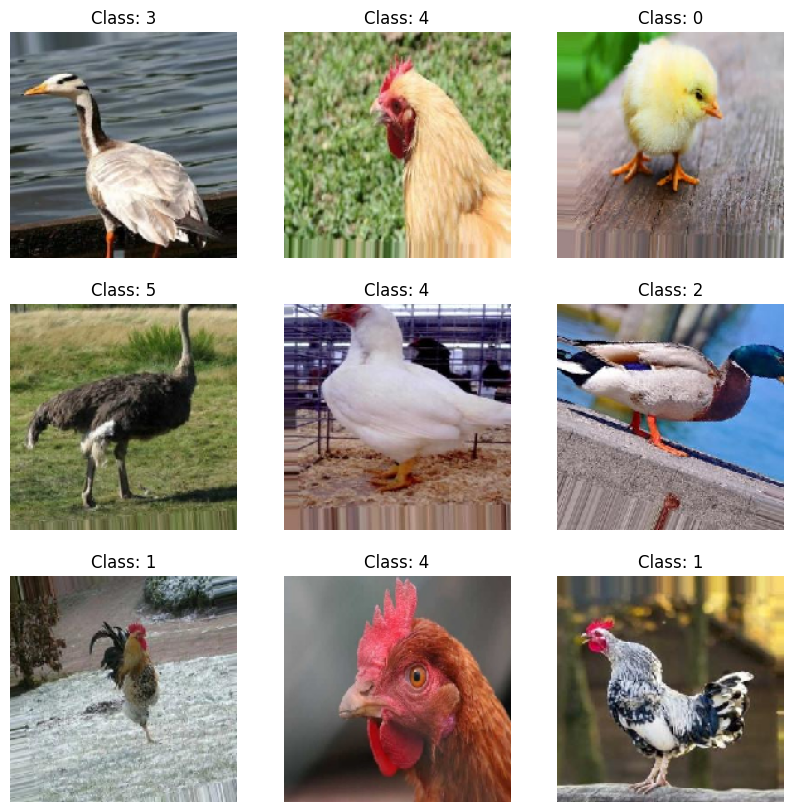

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras


image_size = (180, 180)
batch_size = 20

datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_data = datagen.flow_from_directory(
    train_aug_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=666
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

def plot_examples(data_gen):
    images, labels = next(data_gen)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {labels[i].argmax()}")
        plt.axis("off")
    plt.show()

plot_examples(train_data)

### Архитектура нейросети

In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


model = models.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(image_size[0], image_size[1], 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    
    layers.Dense(len(train_data.class_indices), activation='softmax')
])

lr = 0.0005

optimizer = Adam(learning_rate=lr)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/home/sanero/miniconda3/envs/dl/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733419500.782366   29727 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733419500.785434   29727 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733419500.785526   29

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,687,367 (21.70 MB)

 Trainable params: 5,685,127 (21.69 MB)

 Non-trainable params: 2,240 (8.75 KB)

### Обучение

Epoch 1/45


/home/sanero/miniconda3/envs/dl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733419506.211117   29951 service.cc:146] XLA service 0x7a0d04017640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733419506.211133   29951 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-12-05 22:25:06.255104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-05 22:25:06.479219: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 13/618 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.1502 - loss: 2.3827

I0000 00:00:1733419510.036243   29951 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


618/618 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.4530 - loss: 1.4992 - val_accuracy: 0.5373 - val_loss: 1.3225 - learning_rate: 5.0000e-04
Epoch 2/45
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6614 - loss: 0.9065 - val_accuracy: 0.6759 - val_loss: 0.8816 - learning_rate: 5.0000e-04
Epoch 3/45
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7476 - loss: 0.7033 - val_accuracy: 0.7036 - val_loss: 0.8462 - learning_rate: 5.0000e-04
Epoch 4/45
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8003 - loss: 0.5551 - val_accuracy: 0.6695 - val_loss: 0.8869 - learning_rate: 5.0000e-04
Epoch 5/45
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8438 - loss: 0.4321 - val_accuracy: 0.8891 - val_loss: 0.3261 - learning_rate: 5.0000e-04
Epoch 6/45
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8634 - loss: 0.3743 - val_accuracy: 0.8465 - val_loss: 0.3823 - learning_rate: 5.0000e-04
Epoch 7/45
618/618 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8

2024/12/05 22:29:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/05 22:29:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


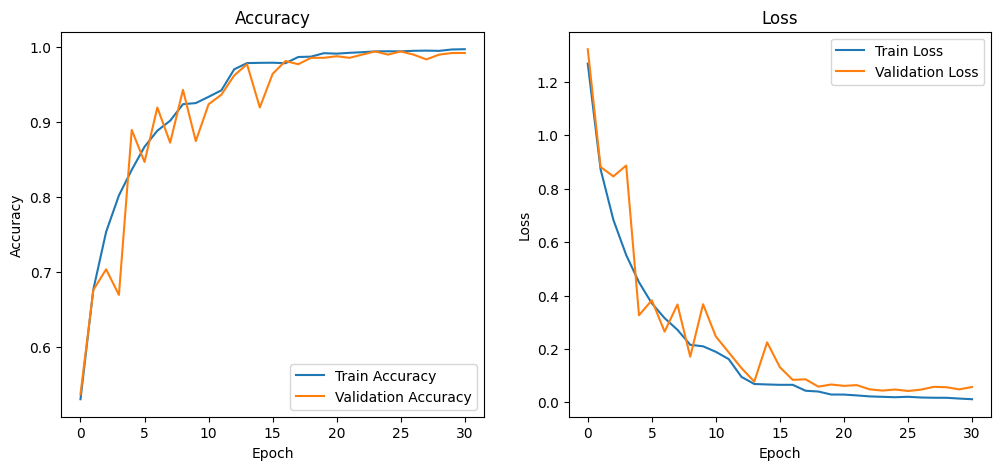

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import mlflow
import mlflow.keras
from tensorflow.keras.utils import plot_model


stop_patience = 5
scheduler_patience = 3

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=stop_patience, 
                           restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=scheduler_patience, 
                                 min_lr=1e-6, 
                                 verbose=1)

history = model.fit(
    train_data,
    epochs=45,
    validation_data=val_data,
    callbacks=[early_stop, lr_scheduler]
)

mlflow.start_run()

mlflow.set_tracking_uri("mlruns")

mlflow.log_param("optimizer", "adam")
mlflow.log_param("loss", "categorical_crossentropy")
mlflow.log_param("learning_rate", lr)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("image_size", image_size)
mlflow.log_param("stop_patience", stop_patience)
mlflow.log_param("scheduler_patience", scheduler_patience)


for epoch in range(len(history.history['accuracy'])):
    mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
    mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
    mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
    mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
    
    
mlflow.keras.log_model(model, "model")

model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
mlflow.log_text("\n".join(model_summary), "model_summary.txt")


def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_training_history(history)

### Матрица ошибок и acc по каждому классу

/home/sanero/miniconda3/envs/dl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step
              precision    recall  f1-score   support

baby chicken       1.00      1.00      1.00        13
        cock       1.00      0.97      0.99        35
        duck       1.00      1.00      1.00        33
       goose       0.98      1.00      0.99        45
         hen       0.97      0.97      0.97        35
     ostrich       1.00      0.98      0.99        44
      turkey       0.97      1.00      0.99        33

    accuracy                           0.99       238
   macro avg       0.99      0.99      0.99       238
weighted avg       0.99      0.99      0.99       238

Accuracy for class 'baby chicken': 1.0000
Accuracy for class 'cock': 0.9714
Accuracy for class 'duck': 1.0000
Accuracy for class 'goose': 1.0000
Accuracy for class 'hen': 0.9714
Accuracy for class 'ostrich': 0.9773
Accuracy for class 'turkey': 1.0000


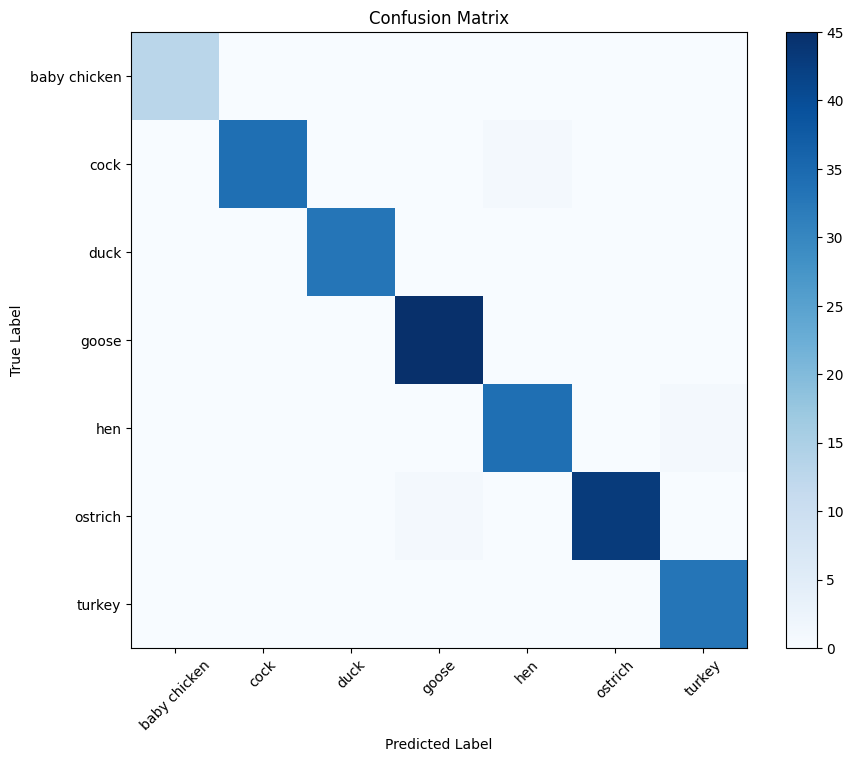

In [5]:
from sklearn.metrics import classification_report, confusion_matrix


y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)

# Точность для каждого класса
class_accuracies = {}
for i, class_name in enumerate(test_data.class_indices.keys()):
    accuracy = cm[i, i] / np.sum(cm[i, :])
    class_accuracies[class_name] = accuracy
    print(f"Accuracy for class '{class_name}': {accuracy:.4f}")

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=range(len(test_data.class_indices)), labels=test_data.class_indices.keys(), rotation=45)
plt.yticks(ticks=range(len(test_data.class_indices)), labels=test_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Проверка на данных, которых не было в датасете

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


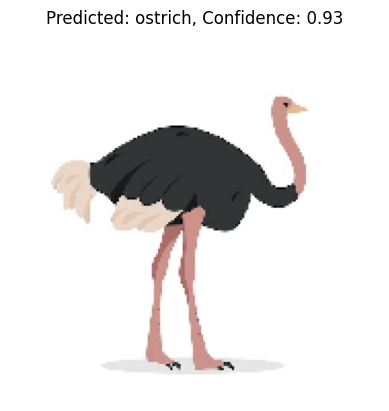

Image: 114.jpg - Predicted: ostrich, Confidence: 0.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


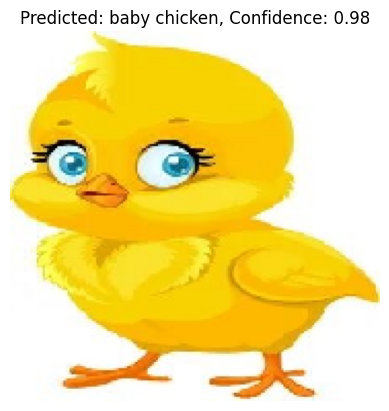

Image: 12.jpg - Predicted: baby chicken, Confidence: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


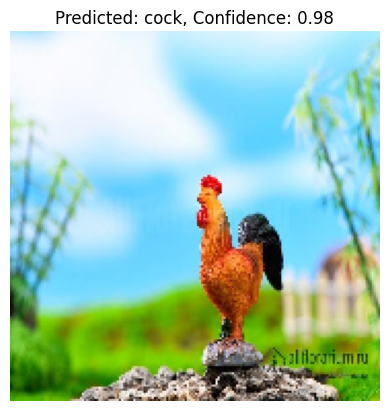

Image: 125.jpg - Predicted: cock, Confidence: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


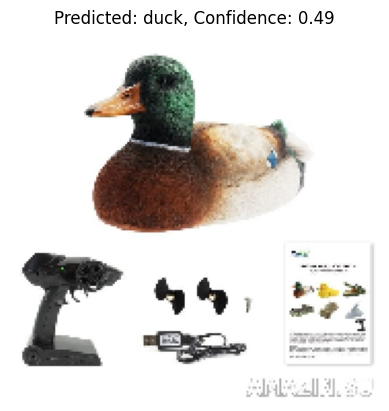

Image: 131.jpg - Predicted: duck, Confidence: 0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


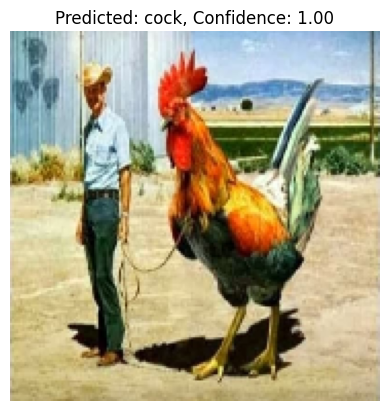

Image: 135.jpg - Predicted: cock, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


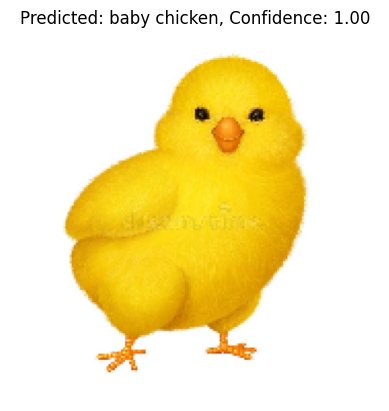

Image: 136.jpg - Predicted: baby chicken, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


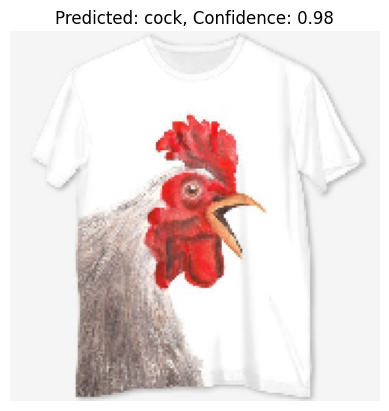

Image: 165.jpg - Predicted: cock, Confidence: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


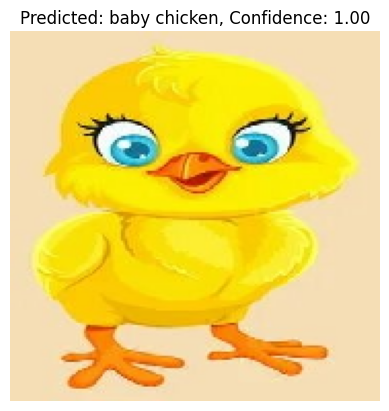

Image: 166.jpg - Predicted: baby chicken, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


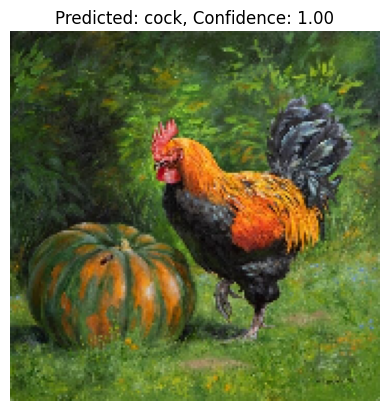

Image: 175.jpg - Predicted: cock, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


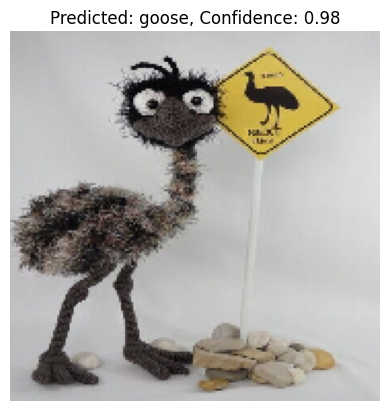

Image: 212.jpg - Predicted: goose, Confidence: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


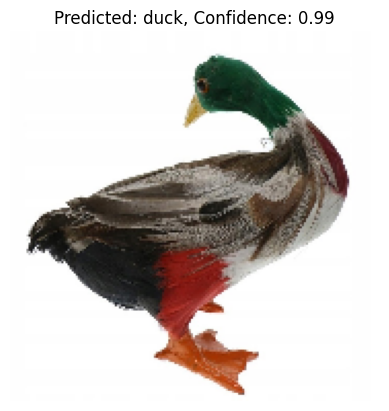

Image: 336.jpg - Predicted: duck, Confidence: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


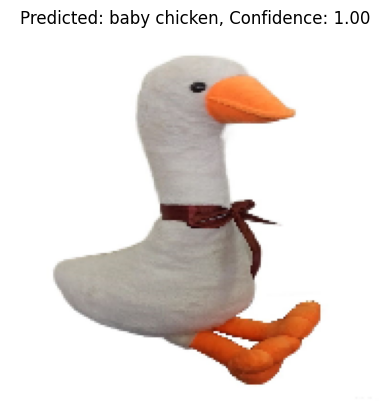

Image: 704.jpg - Predicted: baby chicken, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


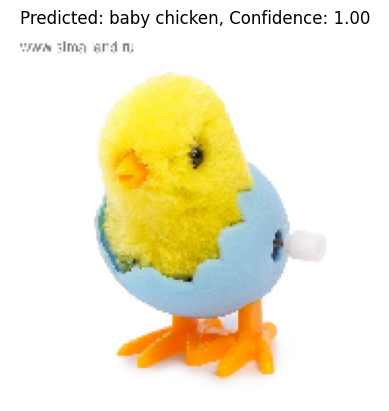

Image: 81.jpg - Predicted: baby chicken, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


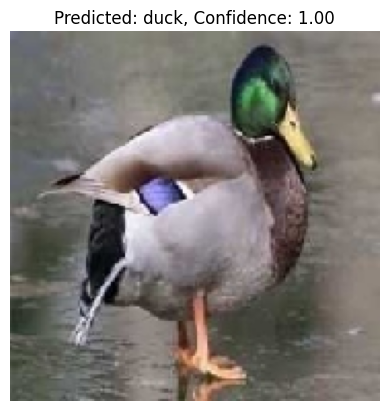

Image: EN22BREUUVJU.jpg - Predicted: duck, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


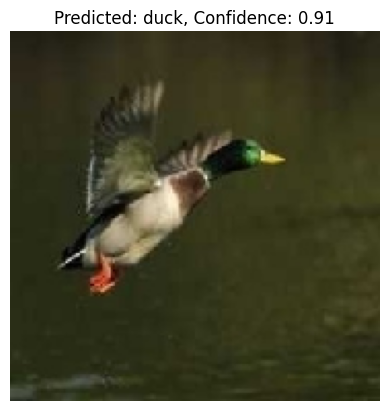

Image: I0PF02CZY7YR.jpg - Predicted: duck, Confidence: 0.91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


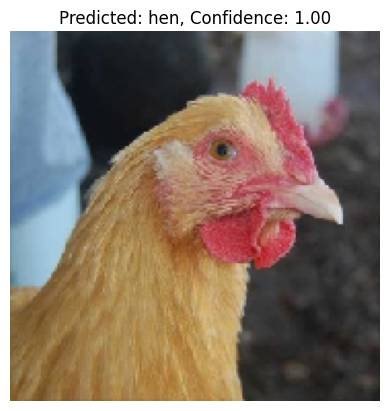

Image: MAKQVAQHP2Y0.jpg - Predicted: hen, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


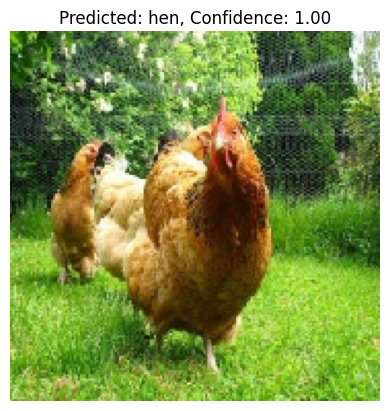

Image: N7PJ1RJI129U.jpg - Predicted: hen, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


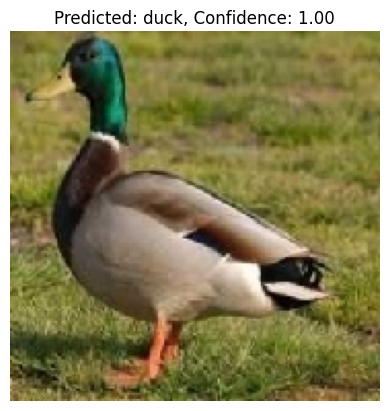

Image: OVGHCZU38B35.jpg - Predicted: duck, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


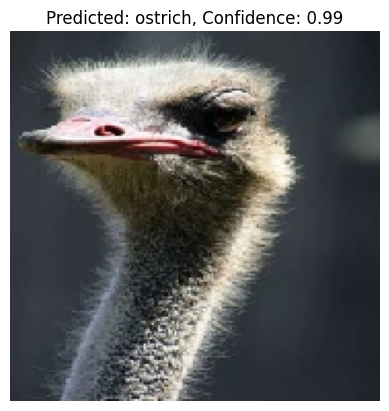

Image: OYTNW8WHYUTW.jpg - Predicted: ostrich, Confidence: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


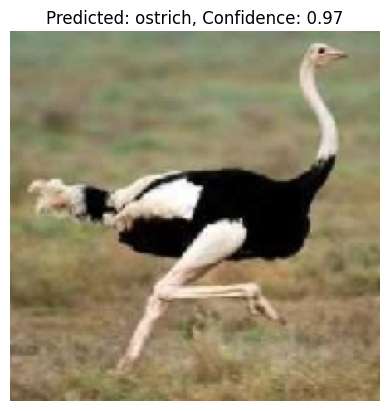

Image: P0Z8ZF6KHI48.jpg - Predicted: ostrich, Confidence: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


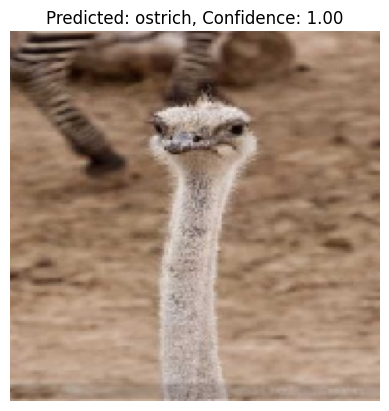

Image: P2QN3NHXY6XY.jpg - Predicted: ostrich, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


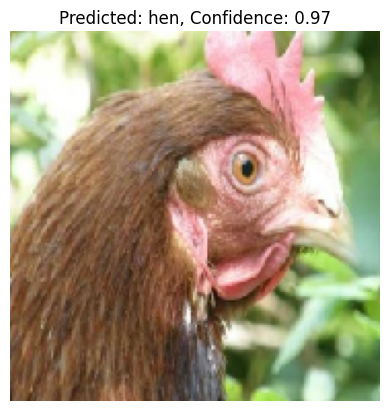

Image: PL4RBNT79IT3.jpg - Predicted: hen, Confidence: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


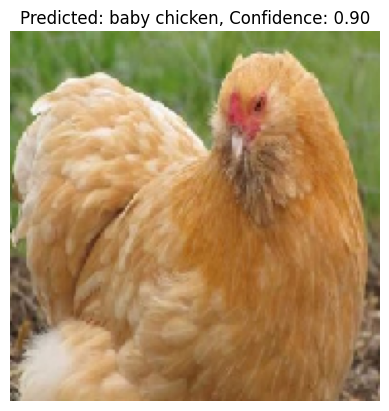

Image: PUUV5CBFSBON.jpg - Predicted: baby chicken, Confidence: 0.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


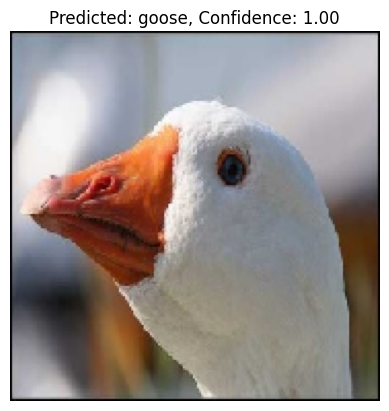

Image: TLFMANB8FIOY.jpg - Predicted: goose, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


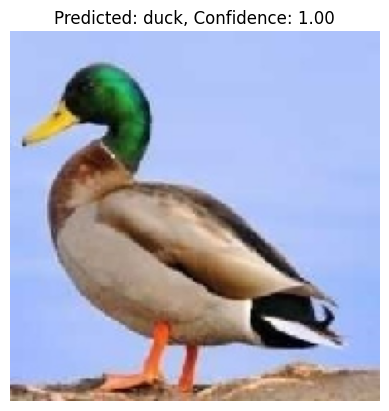

Image: TRBZUCNLNBXK.jpg - Predicted: duck, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


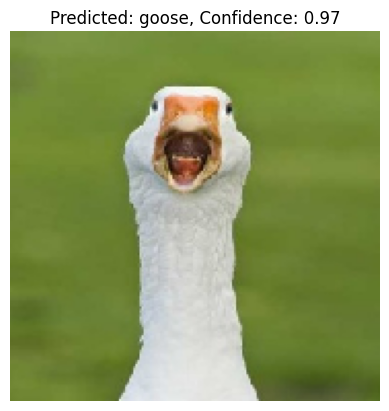

Image: WLH5Z6OH3EFX.jpg - Predicted: goose, Confidence: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


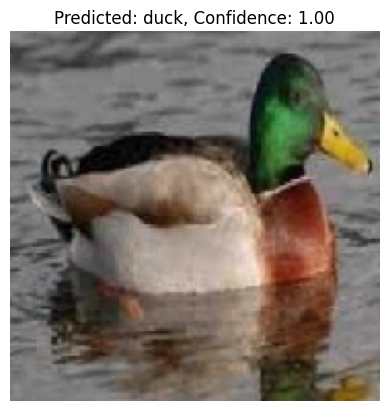

Image: XOH37DM0M1U2.jpg - Predicted: duck, Confidence: 1.00


In [6]:
def prepare_image(image_path, target_size=(image_size[0], image_size[1])):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array


def predict_image(model, image_path):
    prepared_image = prepare_image(image_path)
    prediction = model.predict(prepared_image)
    predicted_class = np.argmax(prediction, axis=1)
    class_names = list(train_data.class_indices.keys())
    predicted_label = class_names[predicted_class[0]]
    confidence = np.max(prediction)
    return predicted_label, confidence


def label_images_in_folder(model, folder_path):
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, fname))]
    
    for image_path in image_paths:
        predicted_label, confidence = predict_image(model, image_path)
        
        img = load_img(image_path, target_size=(image_size[0], image_size[1]))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()

        print(f"Image: {os.path.basename(image_path)} - Predicted: {predicted_label}, Confidence: {confidence:.2f}")


folder_path = 'data/final_test'
label_images_in_folder(model, folder_path)

In [10]:
model.save('..app/models/final_model_99.h5')